# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#7E8083   ; overflow:hidden"><b>Import libraries and load data</b></div>

In [1]:
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

torch.cuda.device('cuda')

/root/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dir = '../../data/predict/dataset/10k-15k'
input_length: int  # 每个时间步的输入特征数量
hidden_size = 64
output_size = 1  # 假设每个任务预测3个标签（库的提交数量）
lable_size: int
num_tasks: int    # 假设有3个库
train_window = 12

In [3]:
def process(all):
    data = all.copy().drop(columns=['Core Developers Focus Rate'])
    # data['Target'] = data['Target'].apply(lambda x: ast.literal_eval(x)[0] if x != '[]' else 0)

    # 计算变化百分比
    # data['Target'] = (data['Target'] - data['Commit Count']) / data['Commit Count']

    # 创建新列，根据变化比例进行分类
    # def categorize_change(row):
    #     if abs(row['Target']) > 0.3:  # 超过30%
    #         return 1 if row['Target'] > 0 else 0
    #     else:
    #         return 2  # 未超过30%

    # get_dummies(data['Target'], prefix='Target')


    # data['code_per_file'] = data['Code Lines'] / data['Code Files']
    # data = data[data['Target'] < 400]
    data = data[data['Develop Time'] > 0]
    data = data.drop(columns=['Target'])

    # data['code_line_delta'] = data['Added Code Lines'] - data['Removed Code Lines']
    # data['code_per_commit'] = (data['Added Code Lines'] + abs(data['Removed Code Lines'])) / data['Commit Count']

    data["Fork Count"] = data["Fork Count"].apply(lambda x: x if x != 0 else 1)
    data["Modified File Count (Average)"] = data["Modified File Count (Average)"].astype(int)

    data["PR Length"] = data["PR Length"].astype(int)
    data["PR Length"] = data["PR Length"].replace(0, np.nan)
    data["Created PRs"] = data["Created PRs"].replace(0, np.nan)
    data["Closed PRs"] = data["Closed PRs"].replace(0, np.nan)
    data["Created Issues"] = data["Created Issues"].replace(0, np.nan)
    data["Closed Issues"] = data["Closed Issues"].replace(0, np.nan)

    data = data.replace(np.inf, np.nan)

    data = data.apply(lambda x: x.fillna(x.mean()), axis=0)
    data["PR Length"] = data["PR Length"].astype(int)
    data["Created PRs"] = data["Created PRs"].astype(int)
    data["Closed PRs"] = data["Closed PRs"].astype(int)
    data["Created Issues"] = data["Created Issues"].astype(int)
    data["Closed Issues"] = data["Closed Issues"].astype(int)
    data["Label Counts (Average)"] = data["Label Counts (Average)"].astype(int)

    # # data["PR Length"] = data["PR Length"].astype(int)

    data = data.drop(columns=['Bot Commit', 
                            'Reopened Issues', 
                            'Release Count','Download Count', 
                            'Markdown Files', 'Markdown Lines',
                            'Code Files', 'Code Lines',
                            'Bot Commit', 'Truck Factor',
                            'Code Comments',
                            "PR Length"])

    # data = data.drop(columns=['Commit Count'])

    return data

def count_files_in_directory(directory):
    tensor_list = []
    i = 0
    # 获取目录下的所有文件和文件夹
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file():
                df = pd.read_csv(entry)
                if len(df) < 10:
                    continue
                i += 1

                tensor_list.append(process(df))

    return tensor_list, i

data, num_tasks = count_files_in_directory(dir)
input_length = data[0].shape[1]
lable_size = data[0].shape[1]

In [4]:
# 定义数据集
class MultiLabelDataset(Dataset):
    def __init__(self, data):
        self.data = data  # data是一个list，包含多个库的提交历史数据

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 假设每个库的数据是一个时间序列，返回特征和多标签
        library_data = self.data[idx]
        X = [i[0] for i in library_data]
        y = [i[1] for i in library_data]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [5]:
# 自定义collate函数以处理动态填充
def collate_fn(batch):
    inputs, targets = zip(*batch)
    padded_inputs = pad_sequence(inputs, batch_first=True)  # 动态填充输入
    padded_targets = pad_sequence(targets, batch_first=True)  # 动态填充目标
    return padded_inputs, padded_targets

In [6]:
from sklearn.preprocessing import MinMaxScaler


X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# scaler = MinMaxScaler(feature_range=(-1, 1))
# train_data_normalized = scaler.fit(np.concatenate([df.values for df in X_train]))

# for i in range(len(X_train)):
#     X_train[i] = pd.DataFrame(scaler.transform(X_train[i].values), columns=X_train[i].columns)

# for i in range(len(X_test)):
#     X_test[i] = pd.DataFrame(scaler.transform(X_test[i].values), columns=X_test[i].columns)

In [7]:
def create_inout_sequences(input_data, tw):
    input_data = input_data.values.tolist() 
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1]
        train_label = train_label[0][0]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [8]:
for i in range(len(X_train)):
    X_train[i] = create_inout_sequences(X_train[i], train_window)
for i in range(len(X_test)):
    X_test[i] = create_inout_sequences(X_test[i], train_window)

In [9]:
dataset = MultiLabelDataset(X_train)
test = MultiLabelDataset(X_test)

In [13]:
# 定义多任务LSTM模型
class MultiTaskLSTM(nn.Module):
    def __init__(self, lable_size, input_length, hidden_size, output_size):
        super(MultiTaskLSTM, self).__init__()
        self.fc_in_0 = nn.Linear(lable_size, 64)
        self.fc_in_1 = nn.Linear(64, 32)
        self.fc_in_2 = nn.Linear(32, 16)
        self.fc_in_3 = nn.Linear(16, 1)
        self.lstm = nn.LSTM(input_length, hidden_size, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        in_ = []
        for i in range(input_length):
            a = self.fc_in_0(x[i])
            a = self.fc_in_1(a)
            a = self.fc_in_2(a)
            a = self.fc_in_3(a)
            in_.append(a[0])
        in_ = torch.tensor(in_)

        lstm_out, _ = self.lstm(in_.view(len(in_) ,1, -1))
        predictions = self.fc_out(lstm_out.view(len(in_), -1))

        return predictions[-1]

In [14]:
# 创建模型
model = MultiTaskLSTM(lable_size, input_length, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model

MultiTaskLSTM(
  (fc_in_0): Linear(in_features=12, out_features=64, bias=True)
  (fc_in_1): Linear(in_features=64, out_features=32, bias=True)
  (fc_in_2): Linear(in_features=32, out_features=16, bias=True)
  (fc_in_3): Linear(in_features=16, out_features=1, bias=True)
  (lstm): LSTM(12, 64, batch_first=True)
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)

In [16]:
# 训练模型
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


for epoch in range(2):  # 训练50个epoch
    for inputs, targets in dataset:
        for i in range(len(inputs)):
            input = inputs[i]
            target = targets[i]
            optimizer.zero_grad()
            outputs = model(input)  

            loss = criterion(outputs, target)  
            loss.backward()
            optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 1, Loss: 1196.8980712890625
Epoch 2, Loss: 3025.335693359375


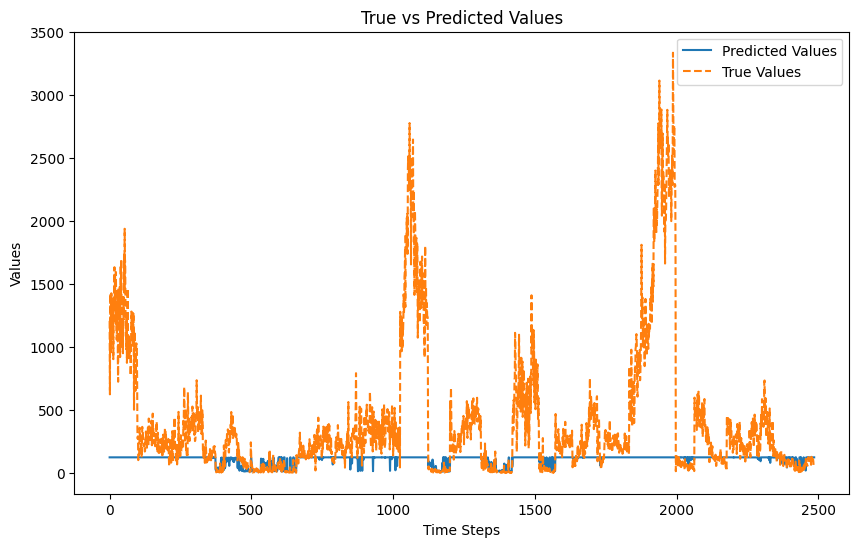

In [17]:
with torch.no_grad():
    predictions_set = []
    true_values_set = []
    
    for inputs, targets in dataset:
        for i in range(len(inputs)):
            input = inputs[i]
            target = targets[i]
            outputs = model(input)  # 添加一个维度以适应LSTM输入

            
            # outputs = scaler.inverse_transform(outputs.repeat(1, 12))[:, 0]
            
            # target = scaler.inverse_transform(target.repeat(1, 12))[:, 0]
            

            predictions_set.extend(outputs.tolist())
            true_values_set.extend([target])  # 假设你想要最后3个目标的值

            # print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

        # break
    


    # 绘制真实值与预测值|
    plt.figure(figsize=(10, 6))
    plt.plot(predictions_set, label='Predicted Values')
    plt.plot(true_values_set, label='True Values', linestyle='--')
        
    plt.title('True vs Predicted Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
